In [1]:
!pip install wordcloud

In [2]:
!pip install -U spacy

  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.7
    Uninstalling thinc-8.1.7:
      Successfully uninstalled thinc-8.1.7
  Attempting uninstall: spacy
    Found existing installation: spacy 3.5.0
    Uninstalling spacy-3.5.0:
      Successfully uninstalled spacy-3.5.0


In [1]:
import csv

#data manipulation
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#text packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
import spacy
from bs4 import BeautifulSoup

#model preparation & selection
from sklearn.model_selection import validation_curve, train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings("ignore")


## Import Data

In [2]:
text_data = pd.read_csv('movies.csv', header=0)
print(text_data.shape)
text_data = text_data.astype(str)
text_data.dtypes, text_data.head()


(14050, 3)


(movie_name       object
 movie_comment    object
 movie_label      object
 dtype: object,
   movie_name                                      movie_comment movie_label
 0    juniper  Filmmakers should showcase Rampling’s indomita...      rotten
 1    juniper  Savilles directorial debut is solid just like ...       fresh
 2    juniper  It feels personal in a lot of the details and ...       fresh
 3    juniper  We've seen this a million times -- but not wit...       fresh
 4    juniper  Juniper takes some time to get where it is goi...       fresh)

### Removing HTML

In [3]:
def remove_html(data):
    soup = BeautifulSoup(data, 'html.parser')
    return soup.get_text()


In [4]:
text_data['movie_comment'] = text_data['movie_comment'].apply(remove_html)
text_data.head()

,movie_name,movie_comment,movie_label
0,juniper,Filmmakers should showcase Rampling’s indomita...,rotten
1,juniper,Savilles directorial debut is solid just like ...,fresh
2,juniper,It feels personal in a lot of the details and ...,fresh
3,juniper,We've seen this a million times -- but not wit...,fresh
4,juniper,Juniper takes some time to get where it is goi...,fresh


## Exploratory Data Analysis

In [5]:
#Using sklearn's Count Vectorizer to calculate frequencies for a WordCloud

stop = STOPWORDS

in_consistent_stopping = ['br', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven',
                          'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn']

for i in in_consistent_stopping:
  stop.add(i)

cv = CountVectorizer(min_df=10, stop_words=stop)

X = cv.fit_transform(text_data['movie_comment'])

X_todict = X.toarray().sum(axis=0)

features = cv.get_feature_names_out()


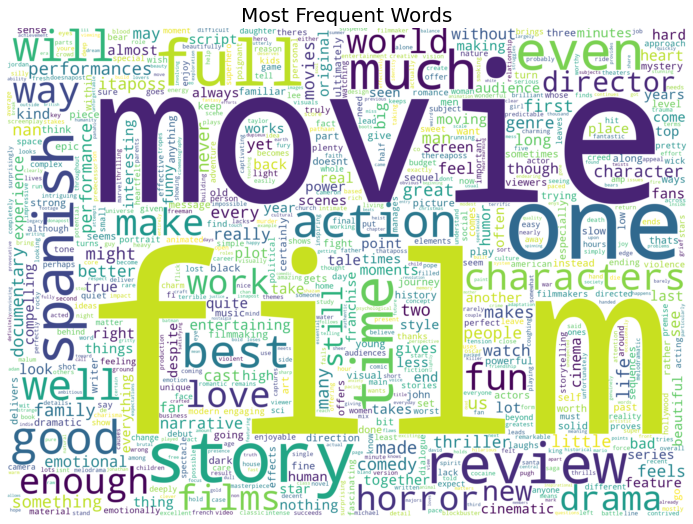

In [6]:
#Creating a dictionary of word frequencies to generate the Word Cloud

word_frequency = {features[i]: X_todict[i] for i in range(len(features))}

sorted_freq = {k: v for k, v in sorted(
    word_frequency.items(), key=lambda item: item[1], reverse=True)}

wordcloud = WordCloud(width=2500, height=1800,
                      max_words=800,
                      stopwords=stop,
                      background_color='white', collocations=False,
                      normalize_plurals=False).generate_from_frequencies(sorted_freq)
plt.figure(figsize=(18, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Frequent Words', fontsize=20)
plt.show()


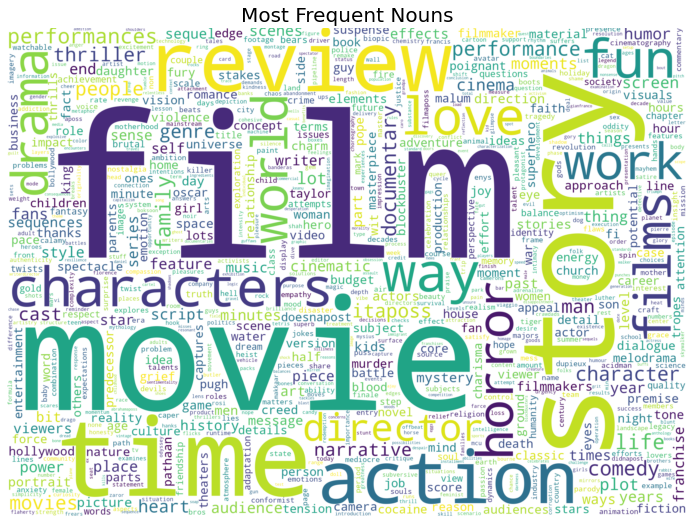

In [7]:
nlp = spacy.load("en_core_web_sm")

nouns_only = {}
counter = 0
for word, freq in sorted_freq.items():
  if counter > 800:  # wordcloud only has 800 words max
    break
  for token in nlp(word):
    if token.pos_ == 'NOUN':
      nouns_only[word] = freq
      counter += 1

wordcloud_noun = WordCloud(width=2500, height=1800,
                           max_words=800,
                           stopwords=stop,
                           background_color='white', collocations=False,
                           normalize_plurals=False).generate_from_frequencies(nouns_only)
plt.figure(figsize=(18, 9))
plt.imshow(wordcloud_noun, interpolation='bilinear')
plt.axis("off")
plt.title('Most Frequent Nouns', fontsize=20)
plt.show()


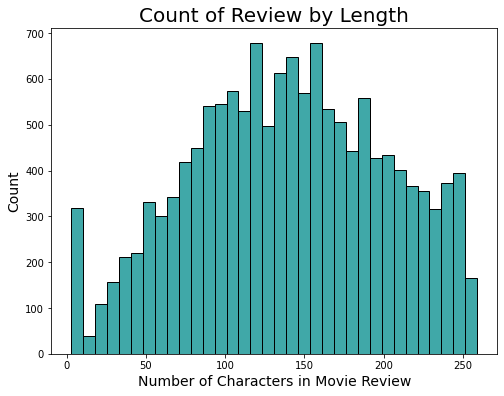

In [8]:
new_data_df = text_data.copy()

new_data_df['Text_Length'] = new_data_df['movie_comment'].str.len()

plt.figure(figsize=(8, 6))
ax = sns.histplot(x=new_data_df['Text_Length'], color='darkcyan')
plt.ylabel('Count', fontsize=14)
plt.xlabel('Number of Characters in Movie Review', fontsize=14)
plt.title('Count of Review by Length', fontsize=20)
plt.show()


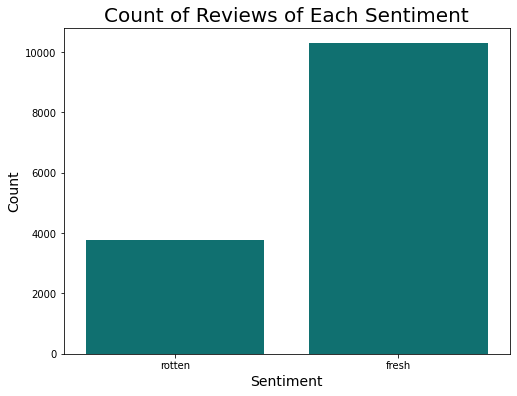

In [9]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=new_data_df['movie_label'], color='teal')
#plt.xlim(0,12000)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Sentiment', fontsize=14)
plt.title('Count of Reviews of Each Sentiment', fontsize=20)
plt.show()


In [10]:
print('There are '+ str(text_data[text_data['movie_label']=='fresh'].shape[0])+' positive reviews.')
print('There are '+ str(text_data[text_data['movie_label']=='rotten'].shape[0]) + ' negative reviews.')

There are 10294 positive reviews.
There are 3756 negative reviews.


## Data Preparation

In [11]:
vec = TfidfVectorizer(stop_words='english', min_df=7, ngram_range = (1,2), max_df = 0.8)
X_data = vec.fit_transform(text_data['movie_comment'])
new_data_df['sentiment_score'] = np.where(new_data_df['movie_label']=='fresh',1,0)
Y_data = new_data_df['sentiment_score']

Xtrain,Xtest,Ytrain,Ytest = train_test_split(X_data, Y_data, test_size=0.15, random_state=0)

## Modeling

In [12]:
# First, plot the results of cross validation
def plot_val_curve(param_range,
                   train_score,
                   test_score,
                   param_name: str,
                   est_name: str,
                   scoring: str):
  '''
  plot_val_curve function takes in the train and test scores from the validation_curve object and plots the validation curve

  Parameters:
    param_range: (array or list object) parameter values tested with the cross validation curve
    train_score: (array or list object) training score results from validation curve
    test_score: (array or list object) validation score results from validation curve
    param_name: (str) hyper-parameter name that is being manipulated
    est_name: (str) name of estimator
    scoring: (str) name of scoring type

  Returns:
    best_param: (float) the best parameter found by validation_curve (characterized by having the best F1 score)

  Prints:
    best_param: (float) the best parameter found by validation_curve (characterized by having the best F1 score)
    Plots the validation curve
  '''
  train_scores_mean = np.mean(train_score, axis=1)
  train_scores_std = np.std(train_score, axis=1)
  test_scores_mean = np.mean(test_score, axis=1)
  test_scores_std = np.std(test_score, axis=1)

  print('The best ' + str(param_name) + ' is ' +
        str(param_range[np.argmax(test_scores_mean)]))

  #Plot CV error as a function of C
  lw = 2
  plt.figure(figsize=(10, 6))
  plt.semilogx(param_range, train_scores_mean, label="Training score",
               color="darkgreen", lw=lw)
  plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
               color="mediumaquamarine", lw=lw)

  a_title = 'Validation Curve with '
  a_title += est_name
  plt.title(a_title)
  plt.xlabel(str(param_name))
  labels = [str(i) for i in param_range]
  plt.xticks(ticks=param_range, labels=labels)
  plt.ylabel(scoring)
  plt.legend(loc="best")
  plt.show()

  return param_range[np.argmax(test_scores_mean)]


In [13]:
#Logistic Regression (Scored by F1)

logr = LogisticRegression(max_iter=5000)
param_range = np.logspace(-4, 5, 18)

train_scores, test_scores = validation_curve(
    logr, X_data, Y_data, param_name="C", param_range=param_range,
    scoring='f1_weighted', n_jobs=1)

#Logistic Regression (Scored by Accuracy)

logr2 = LogisticRegression(max_iter=5000)

train_scores2, test_scores2 = validation_curve(
    logr2, X_data, Y_data, param_name="C", param_range=param_range,
    scoring='accuracy', n_jobs=1)


The best C is 19.684194472866114


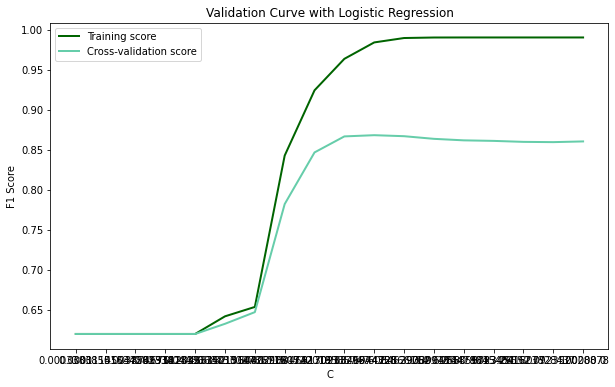

In [14]:
l1 = plot_val_curve(param_range, train_scores, test_scores, 'C', 'Logistic Regression','F1 Score')

The best C is 5.817091329374358


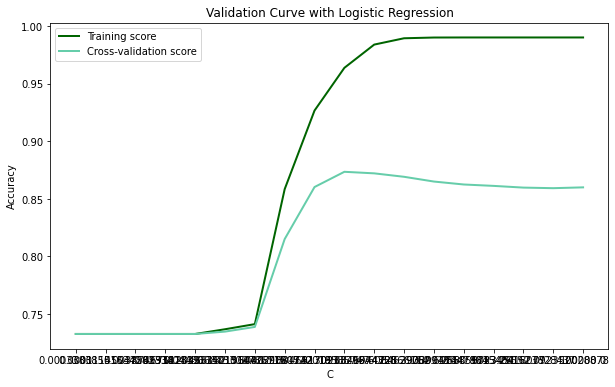

In [15]:
l2 = plot_val_curve(param_range, train_scores2, test_scores2, 'C', 'Logistic Regression','Accuracy')

In [16]:
print('The best value for C is '+str(l1)+' based on F1 score')

logr_best = LogisticRegression(C=l1, max_iter=5000).fit(Xtrain, Ytrain)
logr_score = logr_best.score(Xtest, Ytest)
print('The accuracy for the best Log Reg model is '+str(logr_score))
logr_f1score = f1_score(Ytest, logr_best.predict(Xtest))
print('The F1 for the best Log Reg model is '+str(logr_f1score))


The best value for C is 19.684194472866114 based on F1 score
The accuracy for the best Log Reg model is 0.9117647058823529
The F1 for the best Log Reg model is 0.9420560747663552


In [17]:
#K Nearest Neighbors w/ uniform weights

param_range_n = np.arange(12, 34, 4)

knn = KNeighborsClassifier(weights='uniform')

train_scores_knn, test_scores_knn = validation_curve(
    knn, X_data, Y_data, param_name="n_neighbors", param_range=param_range_n,
    scoring='accuracy', n_jobs=1)


The best n_neighbors is 24


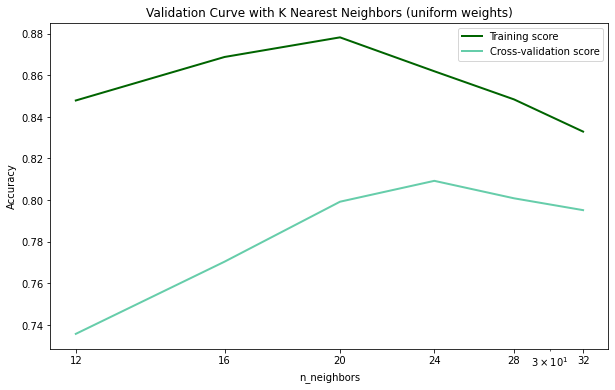

In [18]:
k1 = plot_val_curve(param_range_n, train_scores_knn, test_scores_knn, 'n_neighbors', 'K Nearest Neighbors (uniform weights)','Accuracy')

In [19]:
print('The best value for number of neighbors is ' +
      str(k1)+' for KNN with uniform weights')

best_knn_uni = KNeighborsClassifier(
    n_neighbors=k1, weights='uniform').fit(Xtrain, Ytrain)
knn_uni_score = best_knn_uni.score(Xtest, Ytest)
print('The accuracy for the best KNN model (with uniform weights) is '+str(knn_uni_score))
knn_uni_f1score = f1_score(Ytest, best_knn_uni.predict(Xtest))
print('The F1 for the best KNN model (with uniform weights) is '+str(knn_uni_f1score))


The best value for number of neighbors is 24 for KNN with uniform weights
The accuracy for the best KNN model (with uniform weights) is 0.8358633776091081
The F1 for the best KNN model (with uniform weights) is 0.9005747126436782


In [20]:
#Support Vector Machine (not cross-validating here)

svc_lin = LinearSVC().fit(Xtrain, Ytrain)
svc_lin_score = svc_lin.score(Xtest, Ytest)
print('The accuracy for the Linear SVC model is '+str(svc_lin_score))
svc_lin_f1score = f1_score(Ytest, svc_lin.predict(Xtest))
print('The F1 for the Linear SVC model is '+str(svc_lin_f1score))


The accuracy for the Linear SVC model is 0.9112903225806451
The F1 for the Linear SVC model is 0.9418351477449456
